In [1]:
from minlsh import MinHashLSHiForest
import data_loader
import numpy as np
from sklearn.metrics import roc_auc_score
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# unswの実験
print("Results of UNSW:")
X_train, y_train, X_test, y_test, y_cat = data_loader.load_unsw_for_minhash()
print(f"X_train size is {len(X_train)}")
print(f"X_test size is {len(X_test)}")
X_train.head(5)
y_train.head()

Results of UNSW:
X_train size is 56000
X_test size is 82332


0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

In [3]:
# LSHiForestのインスタンス化と学習
lshif = MinHashLSHiForest(n_estimators=100, sample_size=256, eta=1.0)
start = time.time()
lshif.fit(X_train)
stop = time.time()
print(f"Trained Time: {stop -start}")

# 異常スコアの計算
start = time.time()
scores = lshif.decision_function(X_test)
stop = time.time()

# 2. AUCスコアを計算
print(f"Executed Time: {stop - start}")
auc_score = roc_auc_score(y_test, scores)
print(f"AUC Score: {auc_score}")

Trained Time: 0.6157550811767578
Executed Time: 31.391118049621582
AUC Score: 0.7889455268159715


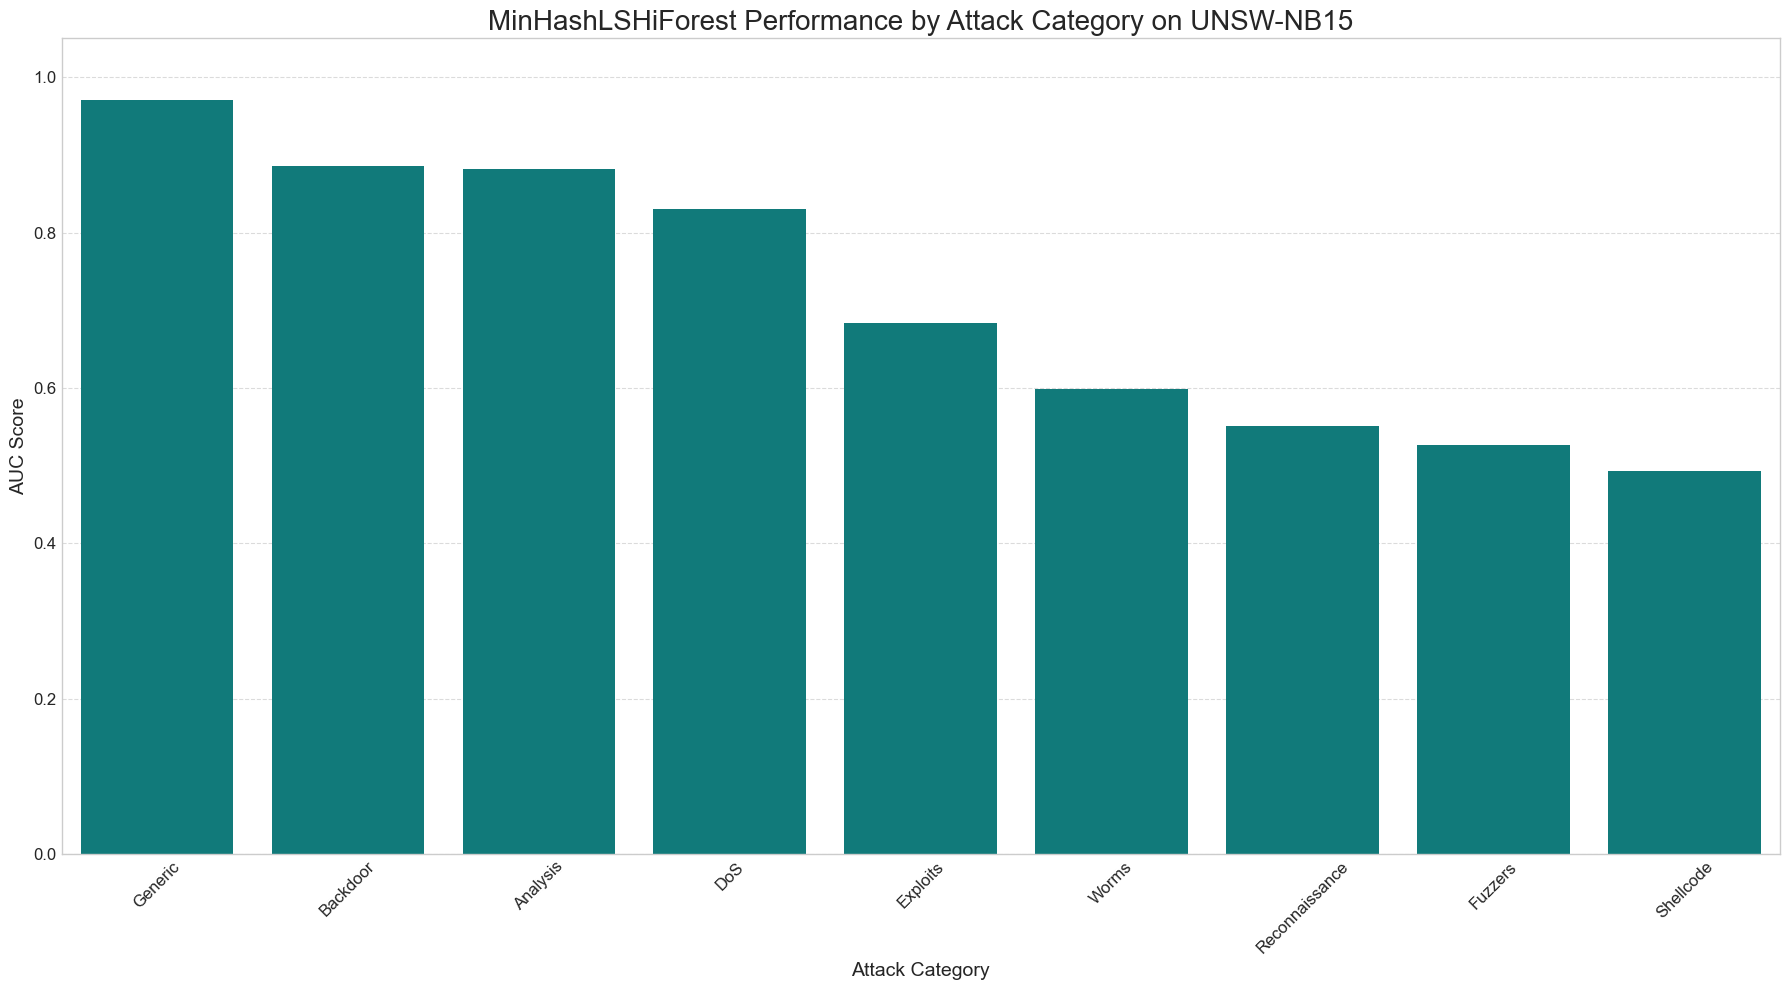

AUC Scores (Each Attack Category vs. Normal Traffic):
  Attack Category  AUC Score
5         Generic   0.970209
1        Backdoor   0.885648
0        Analysis   0.882613
2             DoS   0.831091
3        Exploits   0.683250
8           Worms   0.598410
6  Reconnaissance   0.551491
4         Fuzzers   0.527346
7       Shellcode   0.493158


In [4]:
# 攻撃別手法分析
results_df = pd.DataFrame({
    'attack_cat': y_cat,
    'label': y_test,
    'score': scores 
})

# 2. 正常データと攻撃データを分離
normal_df = results_df[results_df['label'] == 0]
attack_df = results_df[results_df['label'] == 1]

# 3. 各攻撃カテゴリのAUCスコアを計算
auc_scores_by_cat = {}
unique_attack_cats = sorted(attack_df['attack_cat'].unique())

for cat in unique_attack_cats:
    
    current_attack_df = attack_df[attack_df['attack_cat'] == cat]
    eval_df = pd.concat([normal_df, current_attack_df])
    auc = roc_auc_score(eval_df['label'], eval_df['score'])
    auc_scores_by_cat[cat] = auc

# --- 4. グラフの描画 -
plot_df = pd.DataFrame(list(auc_scores_by_cat.items()), columns=['Attack Category', 'AUC Score'])
plot_df = plot_df.sort_values('AUC Score', ascending=False)
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 10))
sns.barplot(data=plot_df, x='Attack Category', y='AUC Score', color='darkcyan', ax=ax)
ax.set_title('MinHashLSHiForest Performance by Attack Category on UNSW-NB15', fontsize=20)
ax.set_xlabel('Attack Category', fontsize=14)
ax.set_ylabel('AUC Score', fontsize=14)
ax.set_ylim(0, 1.05)
ax.tick_params(axis='x', labelrotation=45, labelsize=12) 
ax.tick_params(axis='y', labelsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("AUC Scores (Each Attack Category vs. Normal Traffic):")
print(plot_df.to_string())

In [5]:
# NSL
X_train, y_train, X_test, y_test = data_loader.load_nsl_for_minhash()
y_true = np.array([0 if label == "normal" else 1 for label in y_test])
print(f"X_train size is {len(X_train)}")
print(f"X_test size is {len(X_test)}")

# LSHiForestのインスタンス化と学習
lshif = MinHashLSHiForest(n_estimators=100, sample_size=256, eta=1.0)
start = time.time()
lshif.fit(X_train)
stop = time.time()
print(f"Trained Time: {stop -start}")

# 異常スコアの計算
start = time.time()
scores = lshif.decision_function(X_test)
stop = time.time()

# 2. AUCスコアを計算
print(f"Executed Time: {stop-start}")
auc_scores = roc_auc_score(y_true, scores)
print(f"AUC Score: {auc_scores}")

X_train size is 67343
X_test size is 22544
Trained Time: 0.6609799861907959
Executed Time: 12.01525092124939
AUC Score: 0.9433713691378653


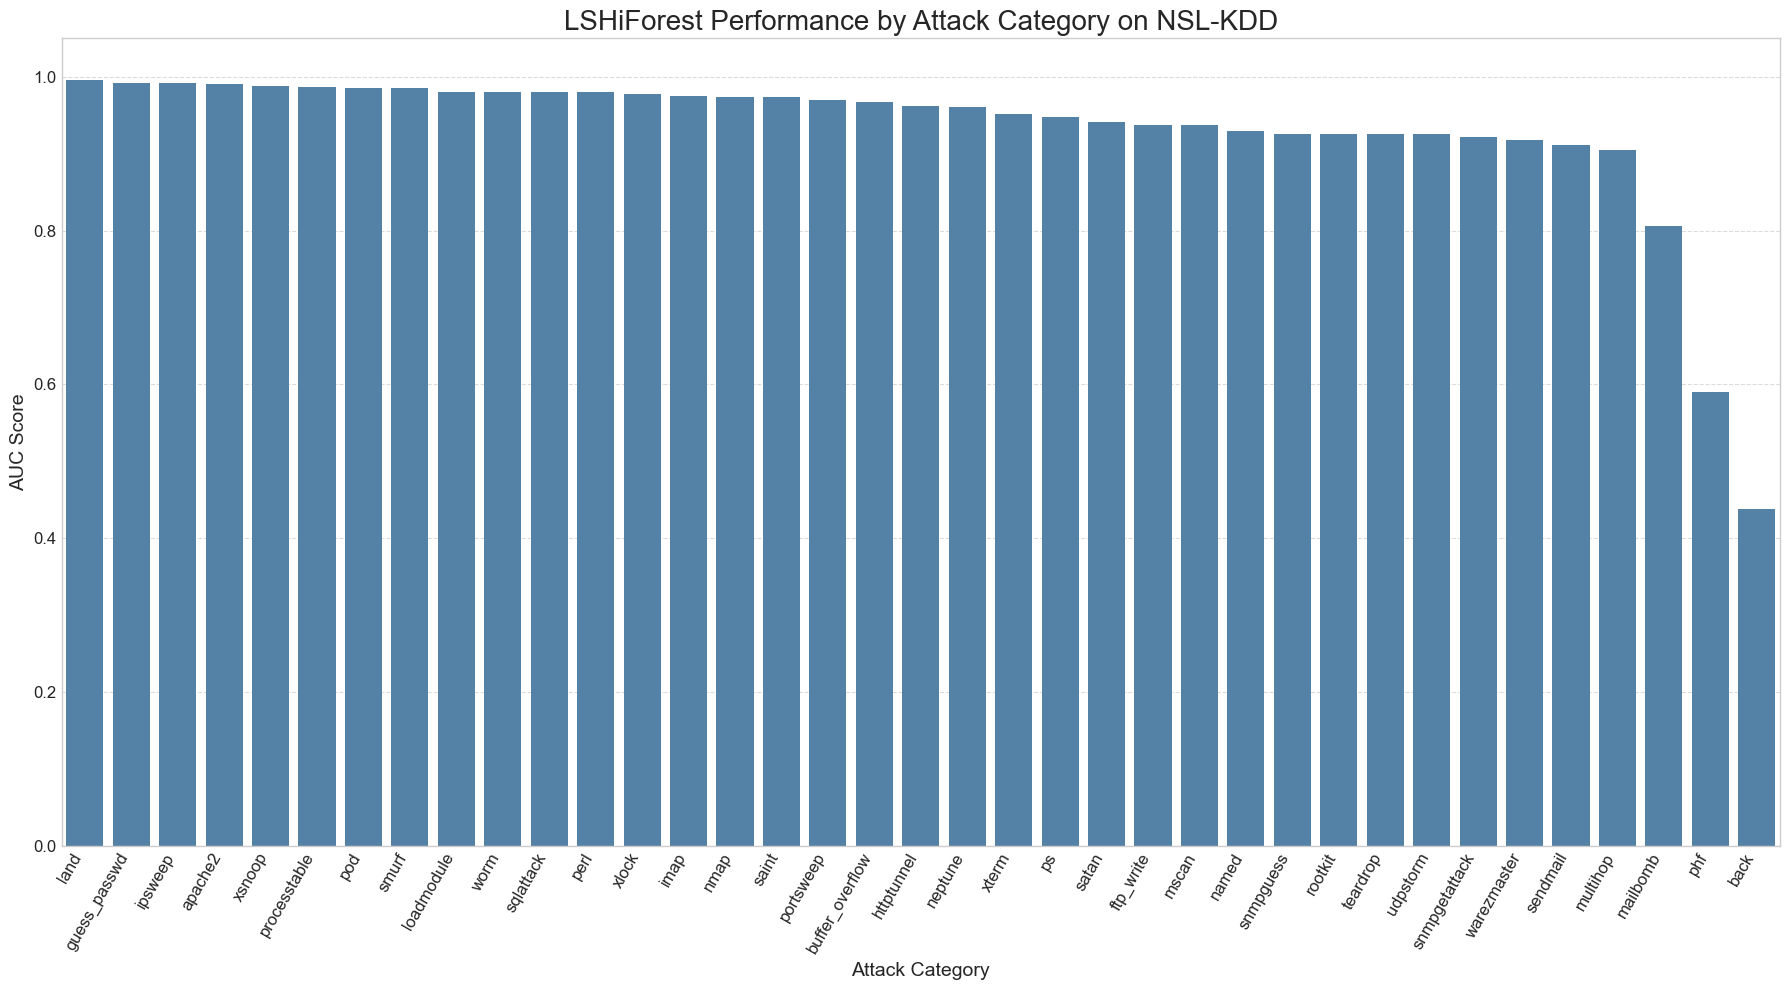

AUC Scores (Each Attack Category vs. Normal Traffic):
    Attack Category  AUC Score
8              land   0.995572
4      guess_passwd   0.992022
7           ipsweep   0.991771
0           apache2   0.990880
35           xsnoop   0.988467
20     processtable   0.986272
18              pod   0.985582
26            smurf   0.985274
9        loadmodule   0.979714
33             worm   0.979714
29        sqlattack   0.979714
16             perl   0.979714
34            xlock   0.977122
6              imap   0.975183
15             nmap   0.974188
23            saint   0.973409
19        portsweep   0.970490
2   buffer_overflow   0.967815
5        httptunnel   0.961685
14          neptune   0.961470
36            xterm   0.952342
21               ps   0.948436
24            satan   0.941421
3         ftp_write   0.937545
11            mscan   0.937012
13            named   0.929807
28        snmpguess   0.925604
22          rootkit   0.925144
30         teardrop   0.925136
31         udpst

In [6]:
# 結果の描写
results_df = pd.DataFrame({
    'attack_cat': y_test,
    'label': [0 if label == 'normal' else 1 for label in y_test],
    'score': scores
})

# 2. 正常データと攻撃データを分離
normal_df = results_df[results_df['label'] == 0]
attack_df = results_df[results_df['label'] == 1]

# 3. 各攻撃カテゴリのAUCスコアを計算
auc_scores_by_cat = {}
unique_attack_cats = sorted(attack_df['attack_cat'].unique())

for cat in unique_attack_cats:
    current_attack_df = attack_df[attack_df['attack_cat'] == cat]
    eval_df = pd.concat([normal_df, current_attack_df])
    auc = roc_auc_score(eval_df['label'], eval_df['score'])
    auc_scores_by_cat[cat] = auc

plot_df = pd.DataFrame(list(auc_scores_by_cat.items()), columns=['Attack Category', 'AUC Score'])
plot_df = plot_df.sort_values('AUC Score', ascending=False)
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 10))
sns.barplot(data=plot_df, x='Attack Category', y='AUC Score', color='steelblue', ax=ax)
ax.set_title('LSHiForest Performance by Attack Category on NSL-KDD', fontsize=20)
ax.set_xlabel('Attack Category', fontsize=14)
ax.set_ylabel('AUC Score', fontsize=14)
ax.set_ylim(0, 1.05)
ax.tick_params(axis='x', labelsize=12) 
plt.setp(ax.get_xticklabels(), rotation=60, ha='right')
ax.tick_params(axis='y', labelsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("AUC Scores (Each Attack Category vs. Normal Traffic):")
print(plot_df)

In [7]:
# unswでbinningした数値特徴量とカテゴリ値で実験
X_train, y_train, X_test, y_test, y_cat = data_loader.load_unsw_binned()
print(f"X_train size is {len(X_train)}")
print(f"X_test size is {len(X_test)}")
X_train.head()

X_train size is 175341
X_test size is 82332


0    {dinpkt:0, ct_srv_src:0, proto:tcp, trans_dept...
1    {dinpkt:0, proto:tcp, trans_depth:0, dloss:0, ...
2    {dinpkt:0, ct_srv_src:0, proto:tcp, trans_dept...
3    {dinpkt:0, ct_srv_src:0, proto:tcp, trans_dept...
4    {dinpkt:0, proto:tcp, trans_depth:0, dloss:0, ...
dtype: object

In [8]:
# LSHiForestのインスタンス化と学習
lshif = MinHashLSHiForest(n_estimators=100, sample_size=256, eta=1.0)
start = time.time()
lshif.fit(X_train)
stop = time.time()
print(f"Trained Time: {stop -start}")

# 異常スコアの計算
start = time.time()
scores = lshif.decision_function(X_test)
stop = time.time()

# 2. AUCスコアを計算
print(f"Executed Time: {stop - start}")
auc_score = roc_auc_score(y_test, scores)
print(f"AUC Score: {auc_score}")

Trained Time: 2.4841017723083496
Executed Time: 388.09034299850464
AUC Score: 0.47709390031741794


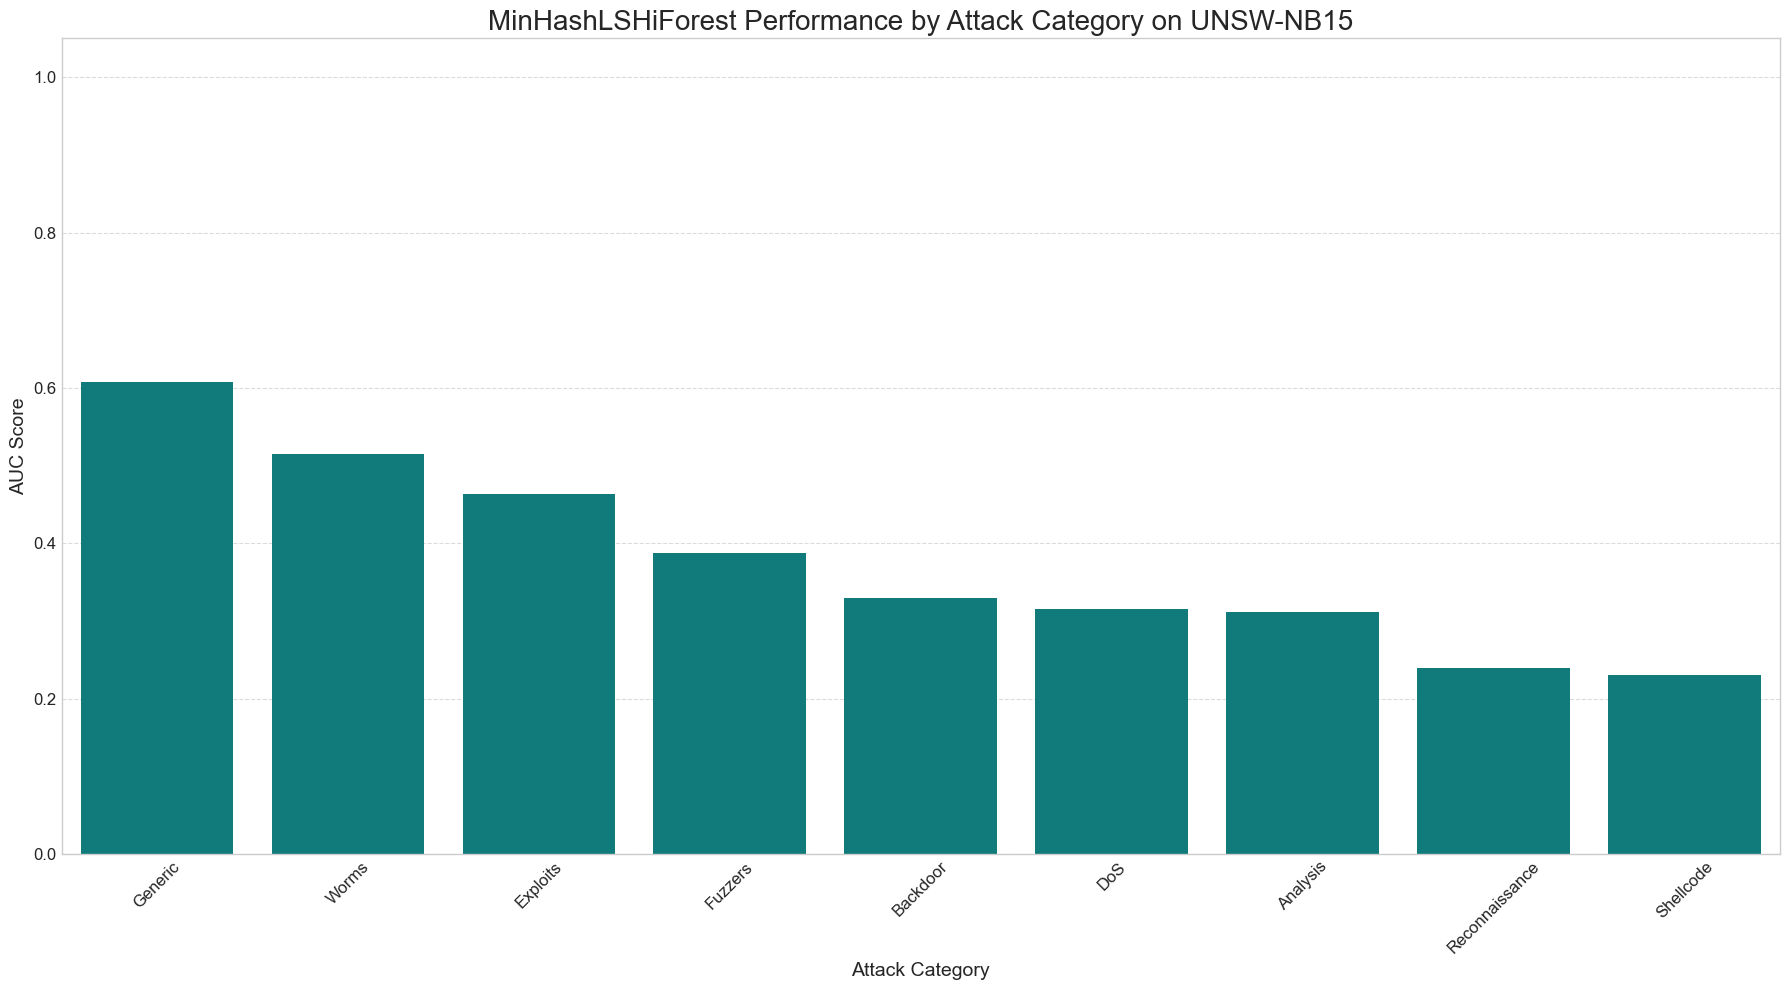

AUC Scores (Each Attack Category vs. Normal Traffic):
  Attack Category  AUC Score
5         Generic   0.607943
8           Worms   0.515455
3        Exploits   0.463802
4         Fuzzers   0.387864
1        Backdoor   0.330052
2             DoS   0.315508
0        Analysis   0.311533
6  Reconnaissance   0.239627
7       Shellcode   0.230184


In [9]:
# 攻撃別手法分析
results_df = pd.DataFrame({
    'attack_cat': y_cat,
    'label': y_test,
    'score': scores  # セル2で計算した異常度スコア
})

# 2. 正常データと攻撃データを分離
normal_df = results_df[results_df['label'] == 0]
attack_df = results_df[results_df['label'] == 1]

# 3. 各攻撃カテゴリのAUCスコアを計算
auc_scores_by_cat = {}
unique_attack_cats = sorted(attack_df['attack_cat'].unique())

for cat in unique_attack_cats:
    
    current_attack_df = attack_df[attack_df['attack_cat'] == cat]
    eval_df = pd.concat([normal_df, current_attack_df])
    auc = roc_auc_score(eval_df['label'], eval_df['score'])
    auc_scores_by_cat[cat] = auc

# --- 4. グラフの描画 -
plot_df = pd.DataFrame(list(auc_scores_by_cat.items()), columns=['Attack Category', 'AUC Score'])
plot_df = plot_df.sort_values('AUC Score', ascending=False)
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 10))
sns.barplot(data=plot_df, x='Attack Category', y='AUC Score', color='darkcyan', ax=ax)
ax.set_title('MinHashLSHiForest Performance by Attack Category on UNSW-NB15', fontsize=20)
ax.set_xlabel('Attack Category', fontsize=14)
ax.set_ylabel('AUC Score', fontsize=14)
ax.set_ylim(0, 1.05)
ax.tick_params(axis='x', labelrotation=45, labelsize=12) # X軸ラベルを回転
ax.tick_params(axis='y', labelsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("AUC Scores (Each Attack Category vs. Normal Traffic):")
print(plot_df.to_string())

In [10]:
# NSL
X_train, y_train, X_test, y_test = data_loader.load_nsl_binned()
y_true = np.array([0 if label == "normal" else 1 for label in y_test])
print(f"X_train size is {len(X_train)}")
print(f"X_test size is {len(X_test)}")

# LSHiForestのインスタンス化と学習
lshif = MinHashLSHiForest(n_estimators=100, sample_size=256, eta=1.0)
start = time.time()
lshif.fit(X_train)
stop = time.time()
print(f"Trained Time: {stop -start}")

# 異常スコアの計算
start = time.time()
scores = lshif.decision_function(X_test)
stop = time.time()

# 2. AUCスコアを計算
print(f"Executed Time: {stop-start}")
auc_scores = roc_auc_score(y_true, scores)
print(f"AUC Score: {auc_scores}")

X_train size is 125973
X_test size is 22544
Trained Time: 2.5921268463134766
Executed Time: 127.11733770370483
AUC Score: 0.7660642790949727


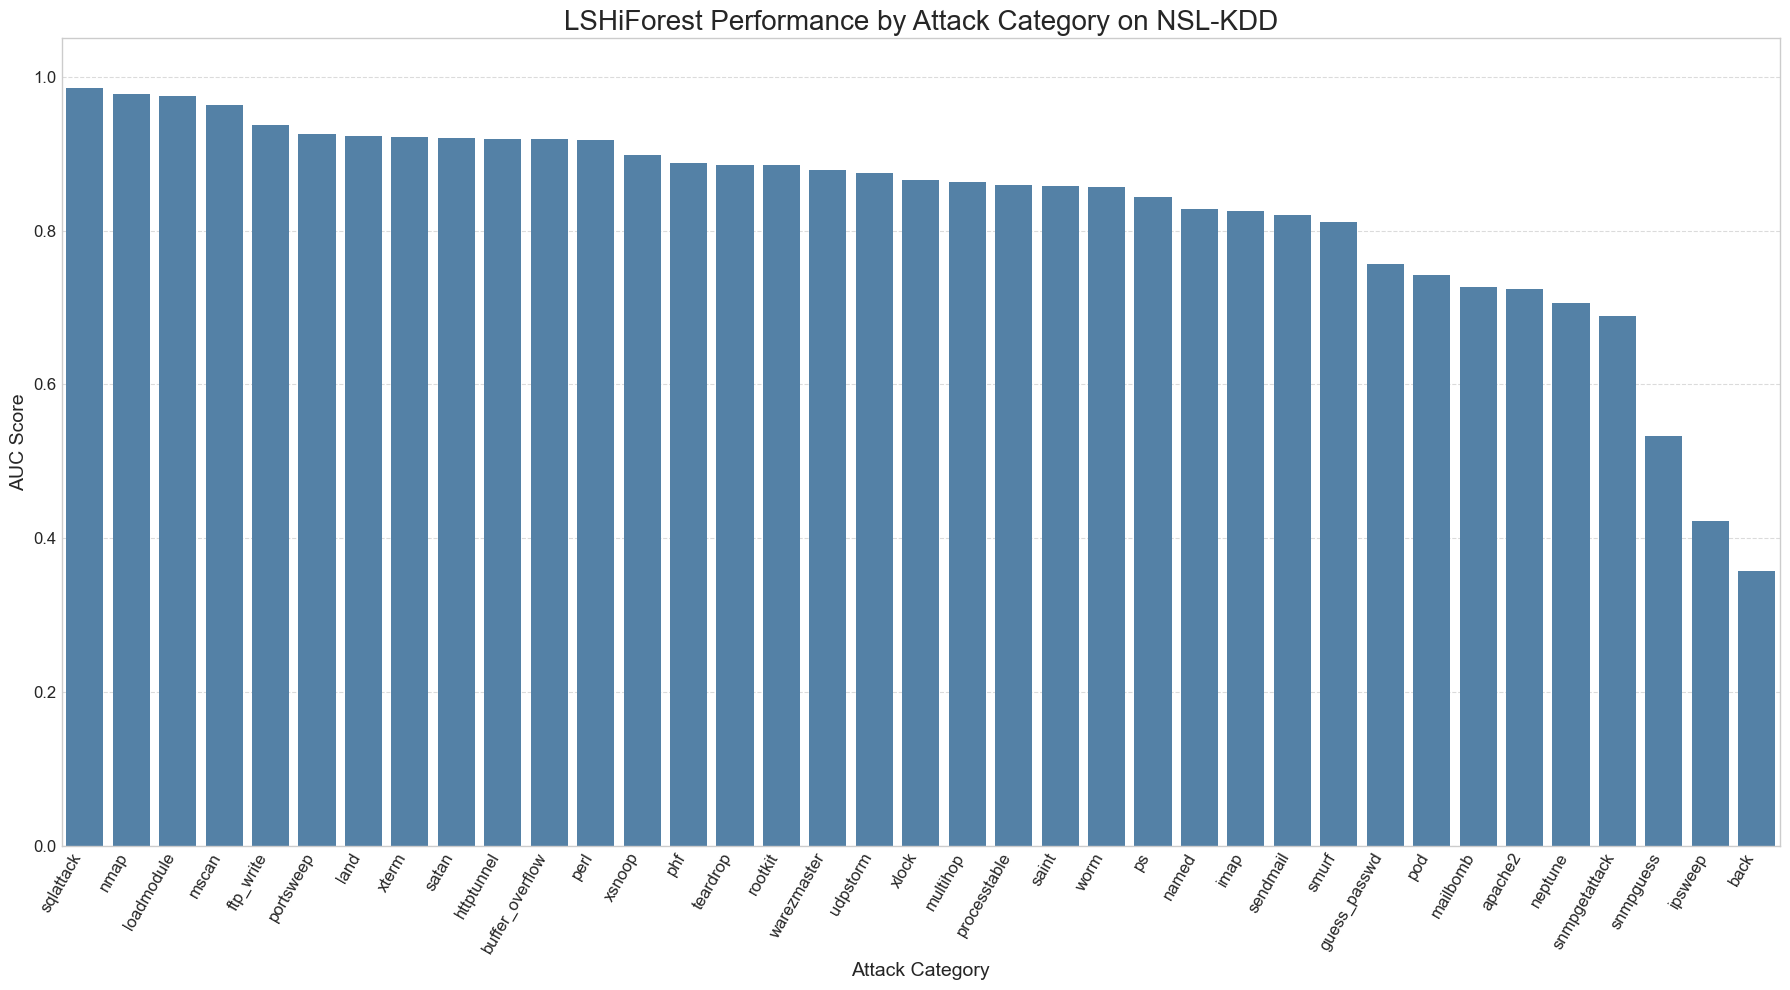

AUC Scores (Each Attack Category vs. Normal Traffic):
    Attack Category  AUC Score
29        sqlattack   0.985686
15             nmap   0.977852
9        loadmodule   0.975080
11            mscan   0.963986
3         ftp_write   0.936996
19        portsweep   0.926233
8              land   0.923136
36            xterm   0.922336
24            satan   0.920317
5        httptunnel   0.919707
2   buffer_overflow   0.919254
16             perl   0.917465
35           xsnoop   0.898813
17              phf   0.888477
30         teardrop   0.885718
22          rootkit   0.884766
32      warezmaster   0.879071
31         udpstorm   0.874369
34            xlock   0.865559
12         multihop   0.863651
20     processtable   0.859792
23            saint   0.857894
33             worm   0.856966
21               ps   0.844369
13            named   0.827757
6              imap   0.825662
25         sendmail   0.820542
26            smurf   0.811761
4      guess_passwd   0.757126
18              

In [11]:
results_df = pd.DataFrame({
    'attack_cat': y_test,
    'label': [0 if label == 'normal' else 1 for label in y_test],
    'score': scores
})

normal_df = results_df[results_df['label'] == 0]
attack_df = results_df[results_df['label'] == 1]
auc_scores_by_cat = {}
unique_attack_cats = sorted(attack_df['attack_cat'].unique())

for cat in unique_attack_cats:
    current_attack_df = attack_df[attack_df['attack_cat'] == cat]
    eval_df = pd.concat([normal_df, current_attack_df])
    auc = roc_auc_score(eval_df['label'], eval_df['score'])
    auc_scores_by_cat[cat] = auc

plot_df = pd.DataFrame(list(auc_scores_by_cat.items()), columns=['Attack Category', 'AUC Score'])
plot_df = plot_df.sort_values('AUC Score', ascending=False)
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 10))
sns.barplot(data=plot_df, x='Attack Category', y='AUC Score', color='steelblue', ax=ax)
ax.set_title('LSHiForest Performance by Attack Category on NSL-KDD', fontsize=20)
ax.set_xlabel('Attack Category', fontsize=14)
ax.set_ylabel('AUC Score', fontsize=14)
ax.set_ylim(0, 1.05)
ax.tick_params(axis='x', labelsize=12) 
plt.setp(ax.get_xticklabels(), rotation=60, ha='right')
ax.tick_params(axis='y', labelsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("AUC Scores (Each Attack Category vs. Normal Traffic):")
print(plot_df)